In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora, models, matutils
import nltk
pd.set_option('display.max_rows', 2000)


In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [4]:
import re
docs_df = pd.read_pickle('docs_raw.pkl')
docs_df['ep_name']=docs_df.ep_name.apply(lambda x: x.strip('- '))
docs_df['no_char']=docs_df.lines.apply(lambda x: len(x))

In [6]:
pam_df = docs_df[docs_df.character=='Pam']
pam_df.drop(columns=['character'], inplace=True)
pam_df['spacy_doc']=list(nlp.pipe(pam_df.lines))

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-6-ea5a8a8eecb3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pam_df['spacy_doc']=list(nlp.pipe(pam_df.lines))


In [140]:
clean_docs = [[token.lemma_.lower() for token in doc
              if (not token.is_stop and not token.is_punct and not token.like_num )&
              (token.pos_=='NOUN' or token.pos_=='PROPN' or
               token.pos_=="X")] for doc in pam_df.spacy_doc]
pam_df['clean_doc']=[' '.join(doc) for doc in clean_docs]
pam_df['clean_doc']=pam_df['clean_doc'].apply(
    lambda x: x.replace('cecelia', 'cece').replace('mother', 'mom').replace('phylli ', 'phyllis '))



<ipython-input-140-31f5f9162585>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pam_df['clean_doc']=[' '.join(doc) for doc in clean_docs]
<ipython-input-140-31f5f9162585>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pam_df['clean_doc']=pam_df['clean_doc'].apply(


In [108]:
#determine topics
def get_topics(n_topics, n_terms, model, term_list):
    for i in range(n_topics):
        topic_weights_full = np.argsort(model.components_[i])
        top_terms =  topic_weights_full[
            len(topic_weights_full): (len(topic_weights_full)-(n_terms+1)):-1]
    
    # get term indices, sorted (descending) by topic weights    
        topic_weights = np.array(model.components_[i][top_terms[0]])
        for b in top_terms[1:]:
            topic_weights= np.append(topic_weights, model.components_[i][b])
    # use the `terms` array to get the actual top terms

            term_names = [terms[item] for item in top_terms]
        print(i, topic_weights, term_names)

In [152]:
stopwords = nltk.corpus.stopwords.words('english')
words_to_cut =['look', 'thank', 'come', 'new', 'thing', 'get', 'great', 'good',
               'day', 'let', 'say', 'start', 'leave', 'new', 'little', 'year', 'guy',
              'phone', 'wait', 'sight', 'sign', 'tell', 'work', 'ok', 'room', 
               'people', 'mm', 'hmm','hour', 'room', 'hour', 'way', 'fact', 'time', 
               'hand', 'thing', 'person', 'office', 'kind', 'door',
               'weekend', 'today', 'stuff', 'place', 'laughs', 'god', 'sigh',
               'da', 'walk', 'aww', 'camera', 'ear', 'end', 'enter', 'face',
               'haha', 'half', 'hoo', 'giggle', 'glass', 'hey', 'kay', 'line', 
               'lot', 'lunch', 'man', 'minute', 'mmm', 'nod', 'ohh', 'okay', 'oooh', 
               'penny', 'smile', 'ugh','umm', 'watch', 'week', 'yay', 'word', 
               'world', 'laugh', 'cell']
stopwords.extend(words_to_cut)

In [82]:
cv = CountVectorizer(lowercase=False, stop_words = stopwords,max_df=0.55) 
X=cv.fit_transform(pam_df.clean_doc)
doc_term_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
terms = np.array(doc_term_df.columns.to_list())

In [153]:
tfidf = TfidfVectorizer(stop_words = stopwords, min_df=0.03,
                       lowercase = False) 
X_idf=tfidf.fit_transform(pam_df.clean_doc)
doc_term_idf_df = pd.DataFrame(X_idf.toarray(), columns=tfidf.get_feature_names())
terms_idf = np.array(doc_term_idf_df.columns.to_list())

In [107]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(doc_term_df)

get_topics(5, 10, pca, terms)

236 [0.78435397 0.42251758 0.1739735  0.16799031 0.10217883 0.07899715
 0.07456007 0.05504567 0.05417789 0.05266477] ['jim', 'chair', 'voicemail', 'message', 'pam', 'copier', 'carpet', 'meredith', 'tie', 'copy']
116 [ 0.66723615 -0.02843504 -0.01451628 -0.03113992  0.01912912  0.78435397
 -0.00463677 -0.07147947 -0.00433254  0.00193902] ['computer', 'andy', 'reception', 'erin', 'wedding', 'jim', 'sheet', 'mom', 'number', 'break']
148 [ 0.69309382  0.01912912 -0.04015283 -0.01137509  0.01061241  0.03732926
  0.00564445 -0.00956495 -0.00629256 -0.00390977] ['mom', 'wedding', 'meeting', 'birthday', 'mema', 'oscar', 'lunch', 'grandma', 'morning', 'candy']
161 [ 0.68366956 -0.08333012  0.07899715  0.00925578  0.05266477 -0.02777671
  0.03732926  0.05417789 -0.03113992  0.02739656] ['chair', 'resolution', 'copier', 'card', 'copy', 'board', 'oscar', 'tie', 'erin', 'catalog']
590 [ 0.74000087 -0.02777671  0.03424943  0.00925578 -0.04187157 -0.01388835
 -0.03113992  0.78435397 -0.03002985 -0.07

In [117]:
from sklearn.decomposition import NMF
nmf = NMF(5)
nmf.fit(doc_term_idf_df)
get_topics(5, 10, nmf, terms)

0 [1.37147549 0.27712386 0.26057224 0.25978503 0.20825149 0.19902895
 0.1806435  0.15508867 0.14439867 0.13480463] ['michael', 'job', 'sale', 'list', 'money', 'month', 'ryan', 'pam', 'delivery', 'scott']
1 [0.79066637 0.37558128 0.29180719 0.26515286 0.25106579 0.20417642
 0.19308759 0.19308759 0.15932776 0.1474264 ] ['jim', 'dwight', 'angela', 'pam', 'wedding', 'friend', 'mifflin', 'dunder', 'toby', 'desk']
2 [1.00613832 0.23480534 0.19813985 0.19406456 0.18369444 0.17037748
 0.16288373 0.13834378 0.13284023 0.1322574 ] ['mom', 'family', 'boss', 'deangelo', 'picture', 'foot', 'birthday', 'wedding', 'cell', 'kid']
3 [1.04092983 0.31046533 0.19419405 0.10359869 0.0970299  0.08543261
 0.06964557 0.06575563 0.06544627 0.06411246] ['chair', 'jim', 'michael', 'card', 'street', 'tie', 'laugh', 'kay', 'boyfriend', 'pam']
4 [0.6887283  0.35068715 0.34294644 0.20941338 0.20657131 0.20560621
 0.19110252 0.18585442 0.18426994 0.16753825] ['kevin', 'world', 'card', 'speech', 'michael', 'priority',

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


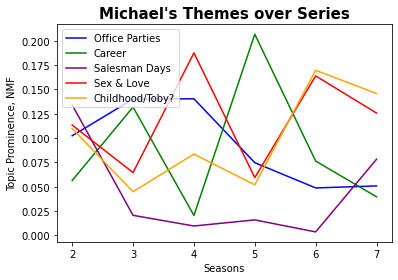

In [343]:
plt.plot(by_season['season'], by_season['family'], color='b')
plt.plot(by_season['season'], by_season['job'], color='g')
plt.plot(by_season['season'], by_season['sales'], color='purple')
plt.plot(by_season['season'], by_season['sex'], color='r')
plt.plot(by_season['season'], by_season['childhood/toby'], color='orange')
plt.title("Michael's Themes over Series", fontsize=15, weight='bold')
plt.legend(['Office Parties', 'Career', 'Salesman Days','Sex & Love', 'Childhood/Toby?'], loc=2)
plt.xlabel('Seasons')
plt.ylabel('Topic Prominence, NMF')
plt.savefig('mike_themes.png', transparent=True)
plt.show()


In [308]:
from sklearn.decomposition import NMF
nmf = NMF(5)
nmf.fit(doc_term_df)

/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/aathirachennat/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF(n_components=5)

In [143]:
corpus = matutils.Sparse2Corpus(X_idf.transpose())
id2word = dict((v,k) for k,v in tfidf.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=100)
lda.print_topics()

[(0,
  '0.018*"mom" + 0.014*"andy" + 0.013*"computer" + 0.013*"kevin" + 0.013*"friend" + 0.012*"michael" + 0.011*"bathroom" + 0.010*"date" + 0.009*"coffee" + 0.009*"jim"'),
 (1,
  '0.028*"michael" + 0.017*"jim" + 0.014*"wedding" + 0.013*"sense" + 0.012*"child" + 0.011*"pam" + 0.010*"stanley" + 0.010*"job" + 0.010*"night" + 0.010*"card"'),
 (2,
  '0.035*"michael" + 0.028*"jim" + 0.020*"pam" + 0.017*"dwight" + 0.016*"dunder" + 0.016*"mifflin" + 0.012*"friend" + 0.011*"message" + 0.011*"jan" + 0.011*"angela"'),
 (3,
  '0.023*"michael" + 0.014*"jim" + 0.012*"ryan" + 0.011*"oscar" + 0.011*"bird" + 0.010*"girlfriend" + 0.010*"car" + 0.010*"list" + 0.010*"christmas" + 0.010*"lamp"'),
 (4,
  '0.026*"chair" + 0.019*"michael" + 0.019*"angela" + 0.018*"mom" + 0.013*"sex" + 0.012*"clothe" + 0.012*"date" + 0.011*"birthday" + 0.011*"meeting" + 0.010*"jim"')]

In [155]:
print(len(terms_idf))
terms_idf

267


array(['administrator', 'aisle', 'andy', 'angela', 'apology', 'applause',
       'apple', 'area', 'arm', 'art', 'attention', 'aunt', 'award',
       'baby', 'bag', 'ball', 'bar', 'bathroom', 'bedroom', 'bird',
       'birthday', 'bit', 'boob', 'book', 'boss', 'box', 'boxer',
       'boyfriend', 'brain', 'branch', 'break', 'breakfast', 'breast',
       'brother', 'building', 'business', 'cake', 'candy', 'car', 'card',
       'cat', 'celebrity', 'ceramic', 'chair', 'chance', 'check', 'cheek',
       'cheer', 'child', 'childhood', 'chocolate', 'christmas', 'class',
       'clothe', 'club', 'coffee', 'college', 'committee', 'company',
       'computer', 'conference', 'contest', 'conversation', 'costume',
       'couple', 'course', 'cream', 'creed', 'crew', 'cup', 'dad',
       'darryl', 'date', 'daycare', 'deal', 'deangelo', 'delivery',
       'department', 'design', 'desk', 'difference', 'dinner', 'doctor',
       'dog', 'dream', 'dress', 'drink', 'dumpster', 'dunder', 'dwight',
       'e

In [157]:
from corextopic import corextopic as ct
topic_model = ct.Corex(n_hidden=10, words=[i for i in terms_idf], seed=1)
topic_model.fit(X_idf, words=[i for i in terms_idf], docs=pam_df.clean_doc,
               anchors= [['michael', 'message'], ['jim', 'date', 'fiance'], 
                         ['chair',  'party'], ['art','design']],
               anchor_strength=8)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print(f'{n}: {", ".join(topic_words)}')

0: michael, message, list, check, celebrity, sale, window, love, meeting, scott
1: jim, date, friday, lamp, kevin, business, brain, christmas, report, idea
2: chair, party, salary, halloween, administrator, department, committee, planning, ride, point
3: design, art, class, pratt, ceramic, note, tom, york, ring, toby
4: bird, warehouse, funeral, coffee, song, suit, strength, stamford, speech, parody
5: video, clothe, apology, press, movie, bag, shop, woman, shirt, candy
6: machine, ball, star, floor, relationship, vance, book, stall, valentine, fry
7: surprise, town, question, baby, mistake, kelly, doctor, andy, theory, sheet
8: deangelo, fish, flower, jo, family, foot, picture, boss, award, dream
9: fridge, house, towel, mess, game, paper, health, cream, ice, contest


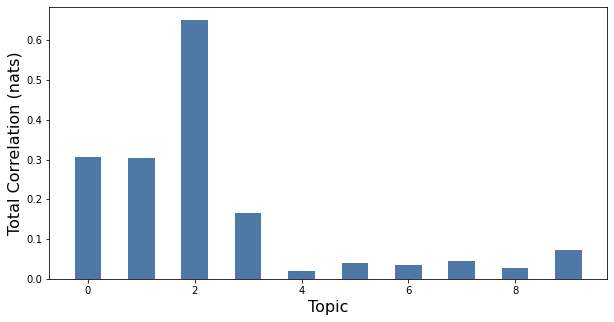

In [158]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [160]:
topic_model.p_y_given_x.shape

(66, 10)

In [165]:
topic_columns = ['michael', 'jim_romance', 'party_office_admin', 'art_career', 'odd_assistant_tasks']
ct_df = pd.DataFrame(topic_model.p_y_given_x[:, 0:5], columns=topic_columns)
pam_df.reset_index(inplace=True, drop=True)
ct_pred_full = pd.merge(pam_df.iloc[:, [0,1]],
                        ct_df, right_index=True, left_index=True)
ct_pred_full = ct_pred_full.sort_values('episode_no')
ct_pred_full.reset_index(inplace=True, drop=True)


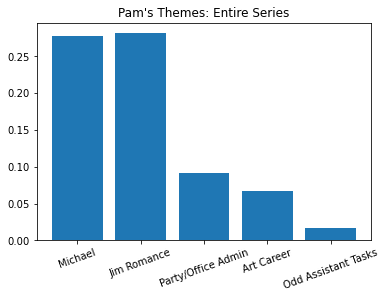

In [168]:
topic_columns = [1, 2, 3, 4, 5]
all_time = []
for i in range(2,7):
    all_time.append(np.mean(ct_pred_full.iloc[:, i]))


plt.bar(topic_columns, all_time)
plt.xticks( [1, 2, 3,4,5], 
           labels= ['Michael', 'Jim Romance', 'Party/Office Admin', 'Art Career', 'Odd Assistant Tasks'],
           rotation=20)
plt.title("Pam's Themes: Entire Series")
plt.show()

In [174]:
pam_df.columns.tolist()

['episode_no',
 'ep_name',
 'lines',
 'season',
 'ep',
 'no_char',
 'spacy_doc',
 'clean_doc']

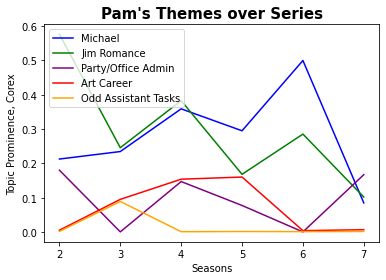

In [175]:
ct_pred_full['season']=ct_pred_full['episode_no'].apply(lambda x: x[0])
by_season=ct_pred_full.groupby('season', as_index=False)[
    ['michael', 'jim_romance', 'party_office_admin', 'art_career', 'odd_assistant_tasks']].mean()
plt.plot(by_season['season'], by_season['michael'], color='b')
plt.plot(by_season['season'], by_season['jim_romance'], color='g')
plt.plot(by_season['season'], by_season['party_office_admin'], color='purple')
plt.plot(by_season['season'], by_season['art_career'], color='r')
plt.plot(by_season['season'], by_season['odd_assistant_tasks'], color='orange')

plt.title("Pam's Themes over Series", fontsize=15, weight='bold')
plt.legend(['Michael', 'Jim Romance', 'Party/Office Admin', 'Art Career', 'Odd Assistant Tasks'], loc=2)
plt.xlabel('Seasons')
plt.ylabel('Topic Prominence, Corex')
plt.savefig('pam_themes.png', transparent=True)
plt.show()

([<matplotlib.axis.XTick at 0x7f8f463faf10>,
 [Text(0, 0, 'The Dundies'),
  Text(1, 0, 'Sexual Harassment'),
  Text(2, 0, 'The Fire'),
  Text(3, 0, 'Halloween'),
  Text(4, 0, 'The Fight'),
  Text(5, 0, 'E-Mail Surveillance'),
  Text(6, 0, 'The Injury'),
  Text(7, 0, 'The Carpet'),
  Text(8, 0, "Valentine's Day"),
  Text(9, 0, 'Take Your Daughter to Work Day'),
  Text(10, 0, 'Conflict Resolution'),
  Text(11, 0, 'The Convention'),
  Text(12, 0, 'The Coup'),
  Text(13, 0, 'Grief Counseling'),
  Text(14, 0, 'Initiation'),
  Text(15, 0, 'Diwali'),
  Text(16, 0, 'Branch Closing'),
  Text(17, 0, 'The Merger'),
  Text(18, 0, 'Ben Franklin'),
  Text(19, 0, "Phyllis' Wedding"),
  Text(20, 0, 'Product Recall'),
  Text(21, 0, 'Beach Games'),
  Text(22, 0, 'Fun Run (Parts 1&2)'),
  Text(23, 0, 'Launch Party (Parts 1&2)'),
  Text(24, 0, 'Local Ad'),
  Text(25, 0, 'Survivor Man'),
  Text(26, 0, 'Chair Model'),
  Text(27, 0, 'Did I Stutter?'),
  Text(28, 0, 'Goodbye, Toby (Parts 1&2)'),
  Text(29, 0,

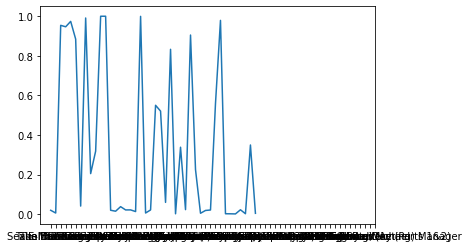

In [190]:
plt.plot(range(len(ct_pred_full[ct_pred_full.season<6][['episode_no']])), 
         ct_pred_full[ct_pred_full.season<6][['jim_romance']])
plt.xticks(range(len(ct_pred_full.ep_name)),
           labels=ct_pred_full.ep_name)

In [193]:
ct_pred_full['character']='pam'
ct_pred_full.to_csv('to_tableau/pam_topics.csv')
cv_counts = CountVectorizer(lowercase=False, stop_words = stopwords, max_features=50) 
X_counts=cv_counts.fit_transform(pam_df.clean_doc)
doc_term_df_counts = pd.DataFrame(X_counts.toarray(), columns=cv_counts.get_feature_names())
terms_counts = np.array(doc_term_df.columns.to_list())
doc_term_df_counts.to_csv('to_tableau/pam_counts.csv')

In [194]:
pam_df.to_csv('to_tableau/pam_lines.csv')

In [195]:
rows=[]
words = doc_term_df_counts.columns.tolist()
counts = []
for i in words:
    counts.append(doc_term_df_counts[i].sum())

top_words = list(zip(words, counts))
for i in top_words:
    row_dict = {'word': i[0], 'count': i[1]}
    rows.append(row_dict)
dwight_counts = pd.DataFrame(rows)
dwight_counts.sort_values('count', ascending=False, inplace=True)  
dwight_counts.to_csv('to_tableau/pam_counts.csv')